## Explore Brody Lab Session Data

2022-02-08: Playing around with accessing the session data via datajoint, extracting info of interest (stage number & delta) and plotting.

In [4]:
from utils import *
from datetime import date
import pickle as pkl
%load_ext autoreload
%autoreload 2

ModuleNotFoundError: No module named 'datajoint'

In [1]:
# grab sessions table
acquisition = dj.create_virtual_module('new_acquisition', 'bl_new_acquisition')

# select animal
subject_session_key = {'session_rat': 'R500'}

# make df
sessions_df = pd.DataFrame((acquisition.Sessions & subject_session_key).fetch(as_dict=True))

# get comments
# sessions_df = parse_comments(sessions_df)

NameError: name 'dj' is not defined

In [2]:
animal_info = pd.read_csv('animal_training_info.csv')

adjust = ['E138', 'E159', 'E160', 'E161', 'R003']

adjust_date = pd.to_datetime(['2020-07-01', '2020-07-01', '2020-09-16', '2021-01-21', '2022-01-01'])

In [3]:
def get_gnp_info(animal_info, adjust_list, adjust_date, fig_save_path=None):
    """
    
    """

    # connect to sessions table
    acquisition = dj.create_virtual_module('new_acquisition', 'bl_new_acquisition')
    
    gnp_info = dict()

    for animal in animal_info['animal']:
        # print(animal)
    
        # make df
        animal_session_key = {'session_rat' : animal}
        sessions_df = pd.DataFrame((acquisition.Sessions & animal_session_key).fetch(as_dict=True))

        # parse comments
        sessions_df = parse_comments(sessions_df)
        
        # adjust date frame via hand tuning params
        if animal in adjust:
            date_idx = adjust.index(animal)
            start_date = pd.to_datetime(adjust_date[date_idx]).date()
            sessions_df = sessions_df[sessions_df['session_date'] > start_date]
        
        # find the session that they first hit always (ignore if they didn't)
        idxs = sessions_df.index[sessions_df['stage_info'] == 'always']
        if idxs.shape == (0,):
            continue
        
        # filter for gnp only given this threshold
        filt_df = sessions_df.loc[0:idxs[0]]
        gnp_df = filt_df[filt_df['stage_info'] == 'grow nose poke']
        
#         # calulate days in stage
#         gnp_days = (gnp_df['session_date'].iloc[-1] - gnp_df['session_date'].iloc[0]).days
        
        # append to dict
        gnp_info[animal] = gnp_df
        # print(gnp_info.keys())
        # # gnp_info[animal] = dict(['ndays', gnp_days])
            

#         # plot
#         fig, ax = plt.subplots(1,1, figsize=(15, 8))
#         plot_delta_timeline(filt_df, animal, ax=ax, gnp_days=gnp_days)

#         # save
#         fig_name = f"{animal}_gnp_stage_plot"

#         if fig_save_path is None:
#             fig_save_path = os.path.join(os.getcwd(), 'figures')
#         else:
#             fig_save_path = fig_save_path

#         plt.savefig(os.path.join(fig_save_path, fig_name), bbox_inches='tight')
#         plt.close("all")
        
    return gnp_info

In [4]:
gnp_dict = get_gnp_info(animal_info, adjust, adjust_date)

Connecting jbreda@datajoint01.pni.princeton.edu:3306


In [6]:
"plotting"
for key, value in gnp_dict.items():
    
        # plot
        fig, ax = plt.subplots(1,1, figsize=(15, 8))
        plot_delta_timeline(value, key, ax=ax, gnp_days=None)

        # save
        fig_name = f"{key}_adjusted_gnp_stage_plot"
        fig_save_path = os.path.join(os.getcwd(), 'figures')

        plt.savefig(os.path.join(fig_save_path, fig_name), bbox_inches='tight')
        plt.close("all")

### Plotting days until delta = 5

In [5]:
def days_until_delta(df, delta_grow):
    """
    given a data frame with grow nose poke session information, determines
    how many days animal takes to reach a certain fixation threshold in s
    
    inputs
    ------
    df : df
        data frame containing session level info for an animal, that has potentially
        been thresholed & wrangled by get_gnp_info()
    delta_grow : int
        value in seconds of target fixation growth

    returns
    -------
    days : int
        number of days it took animal to grow to delta_grow value
    """

    idxs = df.index[df['delta'] >= delta_grow]
    
    # if they haven't reached it yet, use today's date 
    if idxs.shape == (0,):
        date_reached = date.today()
    else:
        date_reached = df['session_date'][idxs[0]]
    
    days = (date_reached - df['session_date'].iloc[0]).days
    
    return days


In [6]:
delta_days_df = pd.DataFrame(columns = ['animal', 'species', 'covid', 
                                        'delta_threshold', 'days'])
delta_growth_thresholds = [1,2,3,4,5]

for idx, animal in enumerate(animal_info['animal']):
    
    if animal == 'E140' or animal not in gnp_dict:
        continue

    gnp_df = gnp_dict[animal]

    for delta_value in delta_growth_thresholds:
        
        days = days_until_delta(gnp_df, delta_value)
        
        delta_days_df = delta_days_df.append({'animal' : animal,
                                              'species' : animal_info['species'][idx],
                                              'covid' : animal_info['covid'][idx],
                                              'delta_threshold' : delta_value,
                                              'days' : days}, ignore_index = True)
        

In [85]:
delta_days_df

,animal,species,covid,delta_threshold,days
0,D083,mouse,pre,1,11
1,D083,mouse,pre,2,12
2,D083,mouse,pre,3,13
3,D083,mouse,pre,4,20
4,D083,mouse,pre,5,21
...,...,...,...,...,...
110,R004,rat,post,1,4
111,R004,rat,post,2,5
112,R004,rat,post,3,9
113,R004,rat,post,4,10


In [7]:
max_growth_df = delta_days_df[delta_days_df["delta_threshold"] == 5]

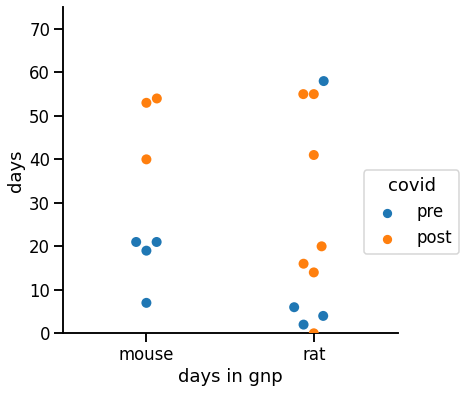

In [80]:
fig, ax = plt.subplots(figsize=(6,6))
sns.set_context("talk")
ax = sns.swarmplot(x='species', y='days', hue="covid", data = max_growth_df, s=10)
ax.set(xlabel = "days in gnp",ylim=(0,75))
# plt.legend(loc='lower right', title='covid')
plt.legend(bbox_to_anchor=(0.9, 0.5), loc=2, borderaxespad=0., title = "covid")
sns.despine()


fig_name = f"gnp_days_zoomed"
fig_save_path = os.path.join(os.getcwd(), 'figures')
plt.savefig(os.path.join(fig_save_path, fig_name), bbox_inches='tight')

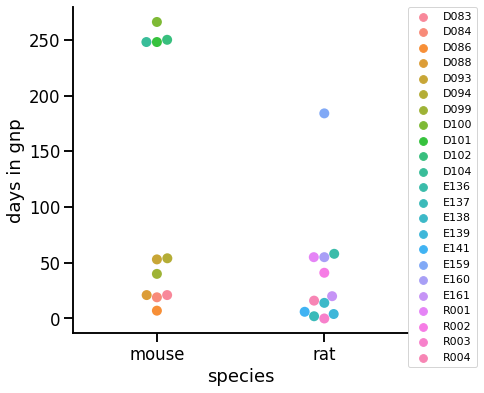

In [29]:
fig, ax = plt.subplots(figsize=(6,6))
sns.set_context("notebook")
ax = sns.swarmplot(x='species', y='days', hue='animal', data = max_growth_df, s=10)
ax.set(ylabel = "days in gnp")
# plt.legend(loc='lower right', title='covid')
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0., title = "")
sns.despine()

fig_name = f"gnp_animal_key_full"
fig_save_path = os.path.join(os.getcwd(), 'figures')
plt.savefig(os.path.join(fig_save_path, fig_name), bbox_inches='tight')

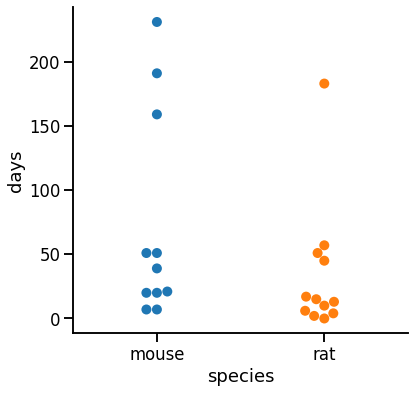

In [81]:
fig, ax = plt.subplots(figsize=(6,6))
sns.set_context("talk")
ax = sns.swarmplot(x='species', y='days', data = delta_days_df.query("delta_threshold == 4"), s=10)
# ax.set(xlabel = "days in gnp",ylim=(0,75))
# plt.legend(loc='lower right', title='covid')
# plt.legend(bbox_to_anchor=(0.9, 0.5), loc=2, borderaxespad=0., title = "covid")
sns.despine()


fig_name = f"gnp_4delta_full"
fig_save_path = os.path.join(os.getcwd(), 'figures')
plt.savefig(os.path.join(fig_save_path, fig_name), bbox_inches='tight')

## plotting growth over time

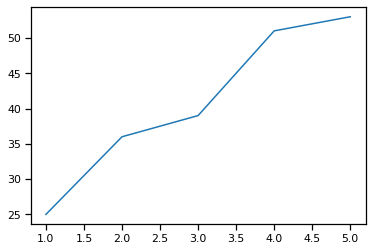

In [50]:
test = delta_days_df[delta_days_df['animal'] == 'D093']
plt.plot(test['delta_threshold'], test['days'])

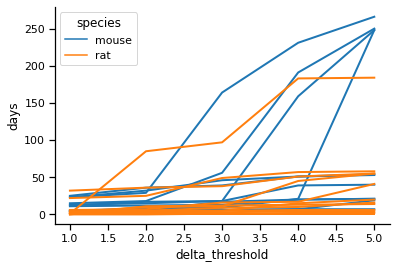

In [65]:
sns.set_context('notebook')

sns.lineplot(x='delta_threshold', y='days', hue='species', units='animal',estimator=None, lw=2, data=delta_days_df)
# plt.legend([],[], frameon=False)
sns.despine()

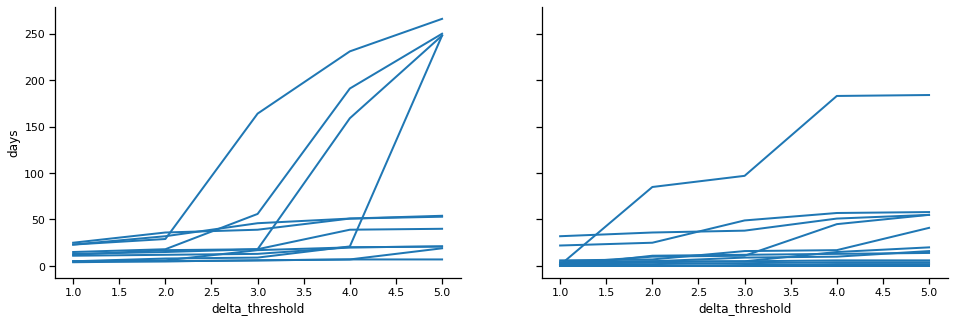

In [74]:
sns.set_context('notebook')

fig, ax = plt.subplots(1,2, figsize=(16,5), sharey=True)

sns.lineplot(x='delta_threshold', y='days', units='animal',estimator=None, lw=2, data=delta_days_df.query("species == 'mouse'"), ax=ax[0])
sns.lineplot(x='delta_threshold', y='days', units='animal',estimator=None, lw=2, data=delta_days_df.query("species == 'rat'"), ax=ax[1])
# plt.legend([],[], frameon=False)
sns.despine()

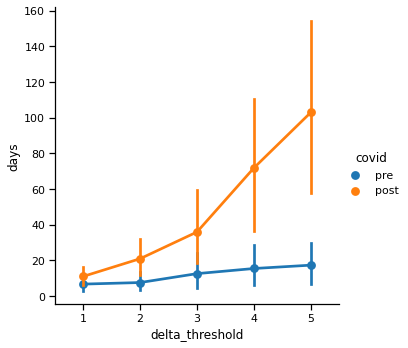

In [51]:
sns.set_context('notebook')

sns.catplot(x='delta_threshold', y='days', hue='covid', kind="point", data=delta_days_df)
sns.despine()

fig_name = "delta_threshold_covid"
fig_save_path = os.path.join(os.getcwd(), 'figures')
plt.savefig(os.path.join(fig_save_path, fig_name), bbox_inches='tight')

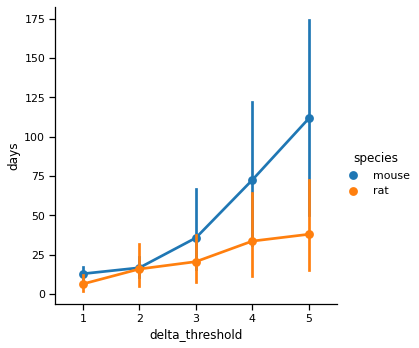

In [54]:
sns.catplot(x='delta_threshold', y='days', hue='species', kind="point", data=delta_days_df)
sns.despine()

fig_name = "delta_threshold_species"
fig_save_path = os.path.join(os.getcwd(), 'figures')
plt.savefig(os.path.join(fig_save_path, fig_name), bbox_inches='tight')

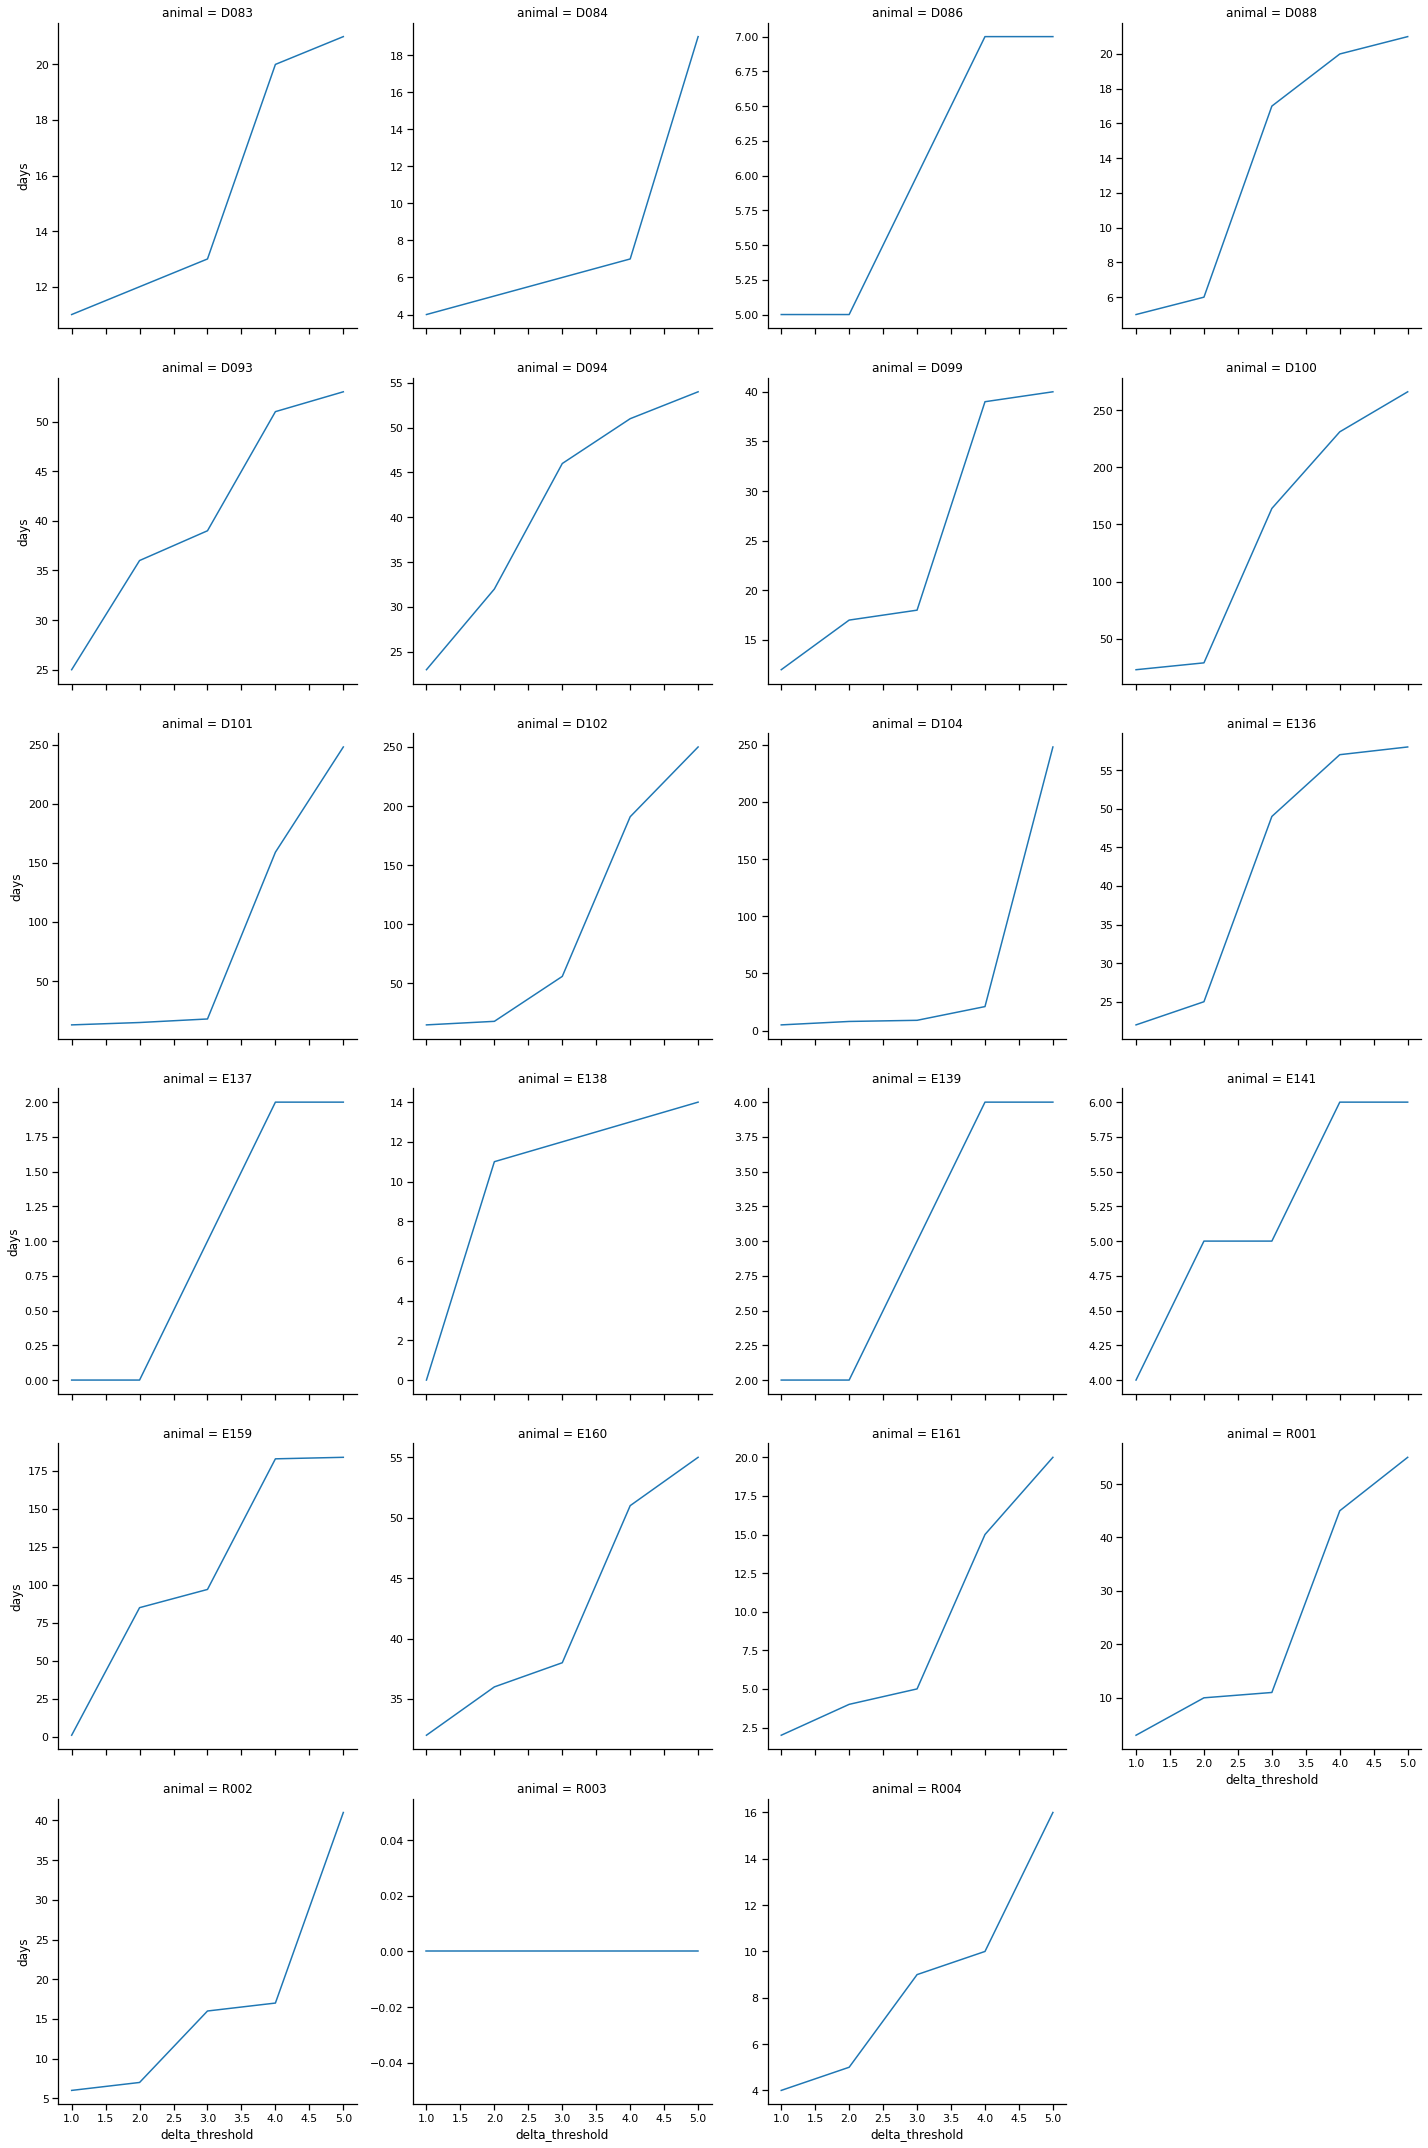

In [56]:
sns.relplot(
    data=delta_days_df, x="delta_threshold", y="days",
    col="animal", col_wrap=4,
    kind="line", facet_kws={'sharey': False, 'sharex': True}
)

fig_name = "delta_threshold_all"
fig_save_path = os.path.join(os.getcwd(), 'figures')
plt.savefig(os.path.join(fig_save_path, fig_name), bbox_inches='tight')